**Time Series ForecasterAutoreg**

Is a class that allows any regressor to be used as a recursive autoregressive forecaster. Meaning it can be used to make preditions for multiple future time steps by recursively feeding it's own predictions back into the model as input.

Here I am going to use from **ForecasterAutoreg** model to predict what the demand for bike rentals would have been in 2020 if there had been no COVID-19 pandemic. In order to achieve this goal I am using data from 2017 and 2018 to train the machine and then data from 2019 to test it, this will help us to find best model with high accuracy. Using that model we can predict 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [3]:
import glob

# Get a list of all CSV files in the directory
file_list = glob.glob('F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\*.csv')


# Create an empty list to hold the DataFrames
df_list = []

# Loop through the CSV files and read them into DataFrames
for file in file_list:
    # Check if the file name contains the years 2019, 2020, or 2021
    if '2018' in file or '2019' in file or '2017' in file:
        # Read the CSV file into a DataFrame and rename the columns
        print(file)
        df = pd.read_csv(file)
        df = df.rename(columns={'ride_id': 'Ride ID', 'rideable_type': 'Rideable Type',
                                'started_at': 'Start date', 'ended_at': 'End date',
                                'start_station_name': 'Start station', 'start_station_id': 'Start station number',
                                'end_station_name': 'End station', 'end_station_id': 'End station number',
                                'start_lat': 'Start station latitude', 'start_lng': 'Start station longitude',
                                'end_lat': 'End station latitude', 'end_lng': 'End station longitude',
                                'Duration': 'Duration (seconds)', 'Bike number': 'Bike Number',
                                'member_casual': 'Member type'})
        #df = df[['Start date', 'End date', 'Member Type']]  # Select only the columns you need
        df_list.append(df)

# Concatenate the DataFrames
df = pd.concat(df_list, ignore_index=True)

F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\2017Q1-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\2017Q2-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\2017Q3-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\2017Q4-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201801_capitalbikeshare_tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201802-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201803-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201804-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201805-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201806-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201807-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201808-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201809-capitalbikeshare

Step 1. Prepare the DATA

In [ ]:
df.head()

,Duration (seconds),Start date,End date,Start station number,Start station,End station number,End station,Bike Number,Member type
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,W00894,Casual
2,1356,2017-01-01 00:07:10,2017-01-01 00:29:47,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W21945,Casual
3,1327,2017-01-01 00:07:22,2017-01-01 00:29:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W20012,Casual
4,1636,2017-01-01 00:07:36,2017-01-01 00:34:52,31258,Lincoln Memorial,31270,8th & D St NW,W22786,Casual


In [4]:
df = df[['Start date', 'Member type']]

In [5]:
df['Member type'] = df['Member type'].replace({'Member': 'member', 'Casual': 'casual'})

In [6]:
for col in df.columns:
    df.rename(columns={col:col.lower().replace(" ","_")},inplace=True)

df.head(0)

,start_date,member_type


In [7]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [8]:
casual = df[df['member_type'] == 'casual'].groupby(pd.Grouper(key = 'start_date', freq = 'MS')).count().rename(columns={'member_type': 'casual_cnt'}).reset_index()
casual = casual[['start_date', "casual_cnt"]]
casual.head()

,start_date,casual_cnt
0,2017-01-01,21870
1,2017-02-01,44022
2,2017-03-01,52184
3,2017-04-01,124240
4,2017-05-01,97763


In [9]:
member = df[df['member_type'] == 'member'].groupby(pd.Grouper(key = 'start_date', freq = 'MS')).count().rename(columns={'member_type': 'member_cnt'}).reset_index()
member = member[['start_date', 'member_cnt']]
member.head()

,start_date,member_cnt
0,2017-01-01,152934
1,2017-02-01,182281
2,2017-03-01,193219
3,2017-04-01,241750
4,2017-05-01,241914


In [10]:
df= pd.merge(member,casual, how='outer', on = "start_date")
df.head()

,start_date,member_cnt,casual_cnt
0,2017-01-01,152934,21870
1,2017-02-01,182281,44022
2,2017-03-01,193219,52184
3,2017-04-01,241750,124240
4,2017-05-01,241914,97763


In [11]:
df = df.assign(total = df['member_cnt'] + df['casual_cnt'])

In [ ]:
df.head()

,start_date,member_cnt,casual_cnt,total
0,2017-01-01,152934,21870,174804
1,2017-02-01,182281,44022,226303
2,2017-03-01,193219,52184,245403
3,2017-04-01,241750,124240,365990
4,2017-05-01,241914,97763,339677


In [12]:
data = df[['start_date', 'total'] ]

In [ ]:
data.head()

,start_date,total
0,2017-01-01,174804
1,2017-02-01,226303
2,2017-03-01,245403
3,2017-04-01,365990
4,2017-05-01,339677


In [13]:
data = data.set_index('start_date')
data = data.rename(columns={'total': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y
start_date,
2017-01-01,174804
2017-02-01,226303
2017-03-01,245403
2017-04-01,365990
2017-05-01,339677


**Time series**

Train dates : 2017-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=24)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


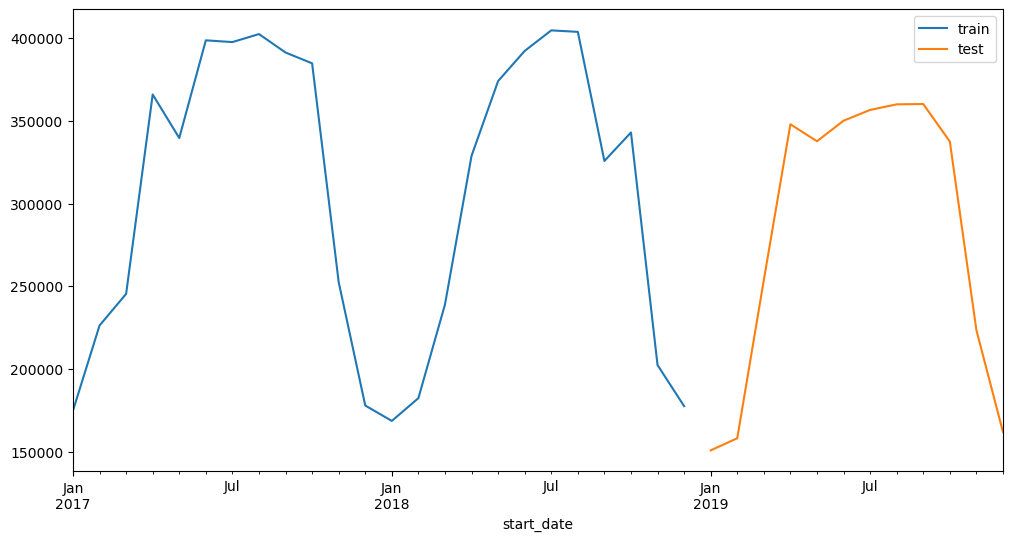

In [14]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

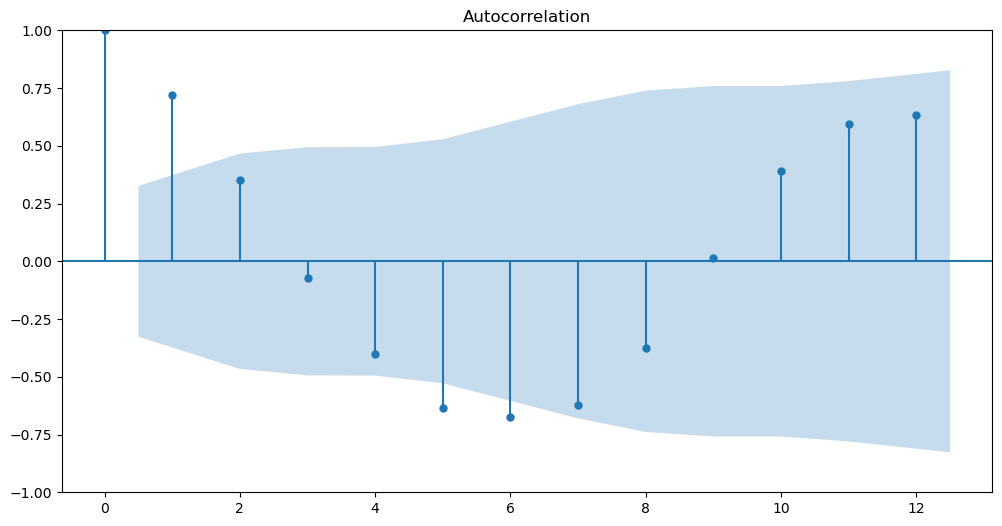

In [15]:
# Autocorrelation plot
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(data.y, ax=ax, lags=12)
plt.show()

Step 2. Create and train Forecaster

In [16]:
# Create and train forecaster with RandomForestRegressor model
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-14 16:22:55 
Last fit date: 2023-04-14 16:22:55 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster

In [17]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-01-01    191470.88
2019-02-01    237684.87
2019-03-01    285235.87
2019-04-01    350778.08
2019-05-01    375790.31
Freq: MS, Name: pred, dtype: float64

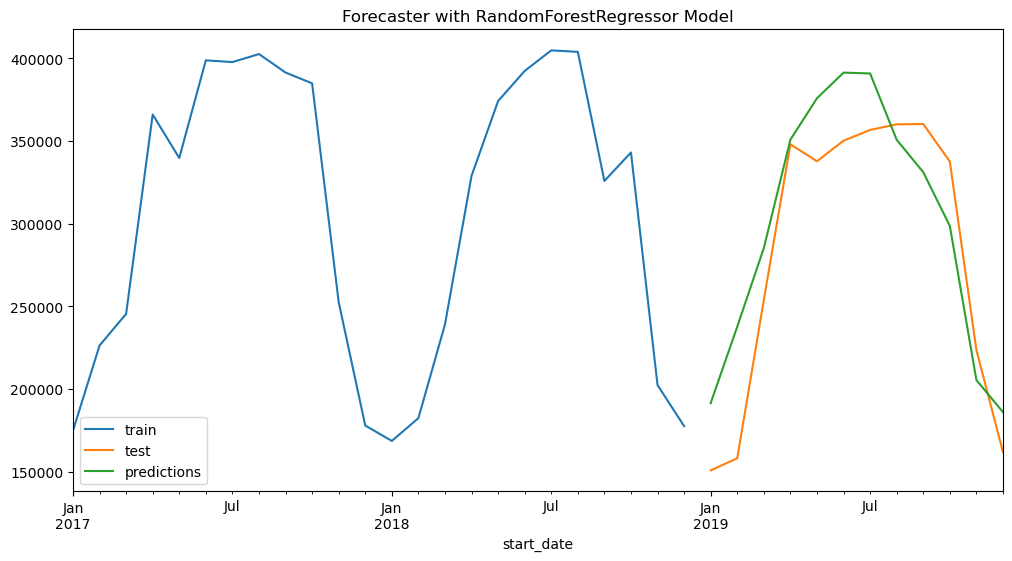

In [30]:
# Plot for RandomForestRegressor model 
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title('Forecaster with RandomForestRegressor Model')
ax.legend()

In [19]:
# Test error using mse
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1388103997.21665


In [20]:
# Test accuracy using r2_score
# ==============================================================================
from sklearn.metrics import r2_score
y_true = data_test['y']
y_pred = predictions
Accuracy = r2_score(y_true, y_pred)*100
print("Accuracy of the model is %.2f" %Accuracy)

Accuracy of the model is 80.21


Ridge Model

In [21]:
# Create and train forecaster with Ridge
# ==============================================================================
from sklearn.linear_model import Ridge


r_forecaster = ForecasterAutoreg(
                regressor = Ridge(random_state=123),
                lags      = 12
             )

r_forecaster.fit(y=data_train['y'])
r_forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-04-14 16:23:19 
Last fit date: 2023-04-14 16:23:19 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster id: None 

In [22]:
# Predictions
# ==============================================================================
steps = 12
r_predictions = r_forecaster.predict(steps=steps)
r_predictions.head(5)

2019-01-01    179255.162901
2019-02-01    142313.497590
2019-03-01    374634.662204
2019-04-01    165526.149796
2019-05-01    607581.848415
Freq: MS, Name: pred, dtype: float64

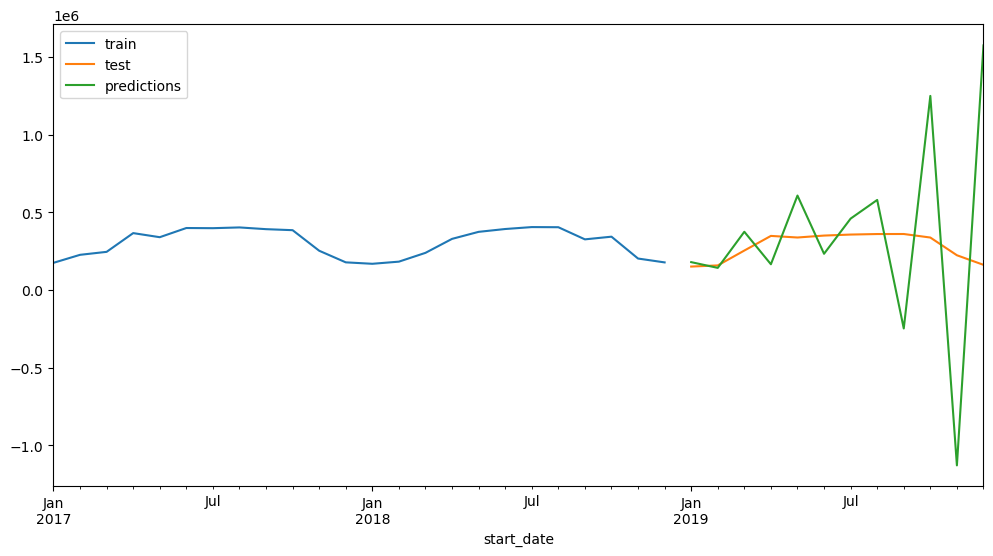

In [23]:
# Plot for ridge 
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
r_predictions.plot(ax=ax, label='predictions')
ax.legend()

In [24]:
# Create and train forecaster with GradientBoostingRegressor
# ==============================================================================
from sklearn.ensemble import GradientBoostingRegressor


gbr_forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = 12
             )

gbr_forecaster.fit(y=data_train['y'])
gbr_forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 123, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-14 16:24:02 
Last fit date

In [25]:
# Predictions
# ==============================================================================
steps = 12
gbr_predictions = gbr_forecaster.predict(steps=steps)
gbr_predictions.head(5)

2019-01-01    176779.651527
2019-02-01    272016.884038
2019-03-01    284052.762631
2019-04-01    352611.400767
2019-05-01    390397.020323
Freq: MS, Name: pred, dtype: float64

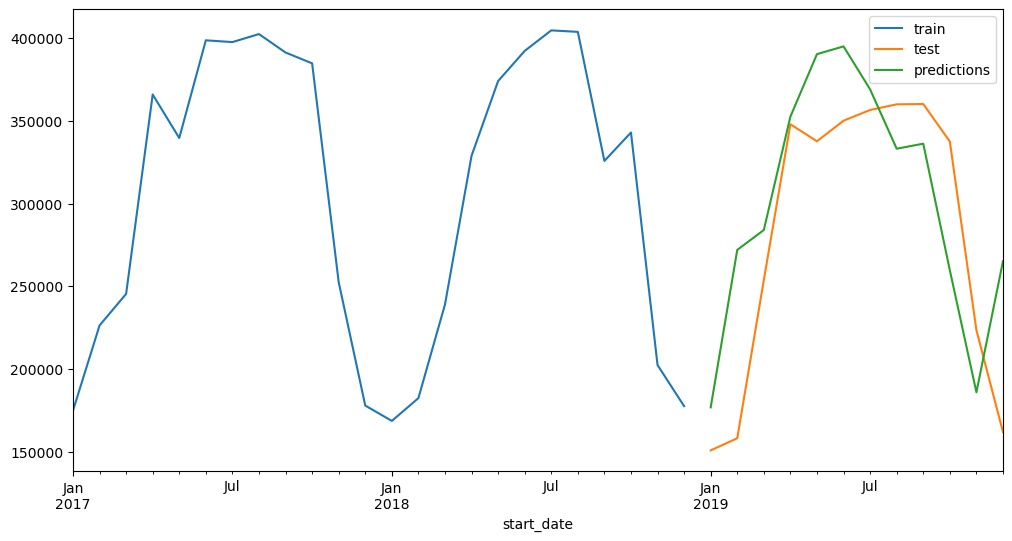

In [26]:
# Plot for gbr 
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
gbr_predictions.plot(ax=ax, label='predictions')
ax.legend()

In [27]:
# Test error using mse
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = gbr_predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 3247121215.3032875


In [28]:
# Test accuracy using r2_score
# ==============================================================================
from sklearn.metrics import r2_score
y_true = data_test['y']
y_pred = gbr_predictions
Accuracy = r2_score(y_true, y_pred)*100
print("Accuracy of the model is %.2f" %Accuracy)

Accuracy of the model is 53.70


We have found that Random Forest Regressor Model with 80.21 % accuracy is our best model, now we can use the model to predict 2020.